# Assignment 1.3

### Exercise 1.3 (40)

We will continue with the preprocessed news dataset.

#### TF-IDF with Scikit-Learn

1. Use the scikit-learn library to compute TF-IDF scores for the news dataset.
2. Write the Python code to transform the news dataset into a TF-IDF matrix using TfidfVectorizer from scikit-learn. Highlight how to adjust parameters like max_features, ngram_range, and stop_words.
3. Select three articles from your dataset and display the top 5 terms with the highest TF-IDF scores for each. Discuss how these terms help in understanding the main topics of the articles.

####  Implementing Okapi BM25

4. Explain the Okapi BM25 algorithm and its advantages over TF-IDF for ranking documents based on query relevance.
5. Implement a basic version of the Okapi BM25 algorithm in Python. Provide a clear explanation of your implementation steps, including the computation of IDF and BM25 scores.
6. Use your Okapi BM25 implementation to rank all news articles in your dataset based on their relevance to a user-defined query (e.g., "climate change"). Display the top 5 ranked articles and discuss the relevance of the results.

#### Exploring Word Embeddings

7. Use a pre-trained Word2Vec or GloVe model (available through libraries like Gensim or SpaCy) to transform words from the news articles into vectors.
8. Select any 10 words from your dataset (e.g., names of organizations, places, and common nouns) and use the pre-trained embeddings to find the 3 most similar words for each. Discuss the semantic similarities and differences among the words and their most similar counterparts.
9. Visualize word embeddings for a subset of words from your dataset using a dimensionality reduction technique (e.g., PCA or t-SNE). Provide a brief explanation of the visualization technique used and interpret the resulting plot.

#### Named Entitiy Recognition

10. Extract and visualize the Named Entities in the dataset. Who are some of known personalities mentioned in the articles. 

## Setup

In [10]:
import json
import os
import re
import math
import random
import time
from collections import Counter, defaultdict

# TF-IDF and Visualization
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np # For array manipulation

# SpaCy (for embeddings, NER, potentially tokenization/lemmatization)
import spacy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Configuration ---
CLEAN_JSON_INPUT = 'scraped_articles_CLEANED.json' # Has 'clean_text'
PROCESSED_JSON_INPUT = 'scraped_articles_PROCESSED.json' # Has token/stem/lemma lists (optional here)

# --- Load Cleaned Data (primarily needed) ---
try:
    with open(CLEAN_JSON_INPUT, 'r', encoding='utf-8') as f:
        cleaned_dataset = json.load(f)
    print(f"Successfully loaded {len(cleaned_dataset)} articles from {CLEAN_JSON_INPUT}")
except Exception as e:
    print(f"ERROR loading {CLEAN_JSON_INPUT}: {e}")
    cleaned_dataset = []

# Extract just the text content for TF-IDF, BM25, NER
corpus = [article.get('clean_text', '') for article in cleaned_dataset if article.get('clean_text')]
print(f"Created corpus with {len(corpus)} non-empty article texts.")

# --- Load SpaCy Model (Explicitly 'en_core_web_md') ---
spacy_model_name = "en_core_web_md" # Target the medium model
nlp = None
try:
    nlp = spacy.load(spacy_model_name)
    print(f"Successfully loaded SpaCy model '{spacy_model_name}'.")
except OSError:
    print(f"SpaCy model '{spacy_model_name}' not found.")
    print(f"Please ensure it's downloaded: python -m spacy download {spacy_model_name}")

Successfully loaded 60 articles from scraped_articles_CLEANED.json
Created corpus with 60 non-empty article texts.
Successfully loaded SpaCy model 'en_core_web_md'.


## TF-IDF with Scikit-Learn

### 1. Use scikit-learn to compute TF-IDF scores.
### 2. Write code using TfidfVectorizer and highlight parameters.

In [ ]:
# --- TF-IDF Vectorization ---

# Initialize the vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    max_df=0.95,
    min_df=2
)

# Fit and transform the corpus
tfidf_matrix = None
feature_names = []
if corpus:
    print("\nFitting TfidfVectorizer and transforming the corpus...")
    start_time = time.time()
    try:
        tfidf_matrix = vectorizer.fit_transform(corpus)
        feature_names = vectorizer.get_feature_names_out()
        end_time = time.time()

        print(f"TF-IDF matrix created successfully in {end_time - start_time:.2f} seconds.")
        print(f"Shape of matrix: {tfidf_matrix.shape}")
        print(f"Number of features: {len(feature_names)}")
        print(f"Sample features: {feature_names[:10]}...")
    except Exception as e:
        print(f"Error during TF-IDF vectorization: {e}")
else:
    print("Corpus is empty. Cannot perform TF-IDF vectorization.")


Fitting TfidfVectorizer and transforming the corpus...
TF-IDF matrix created successfully in 0.06 seconds.
Shape of matrix: (60, 5000)
Number of features: 5000
Sample features: ['00' '00 39' '00 48' '00 cdt' '00 gmt' '00 minutes' '000' '000 owners'
 '000 palestinians' '000 pet']...


#### Adjusting `TfidfVectorizer` Parameters

Here's how to adjust the key parameters for your specific needs:

* **`max_features`**:
    * **Decrease** this number (e.g., from 10000 to 5000) if processing is too slow, memory usage is high, or you suspect very rare words are adding noise.
    * **Increase** or set to `None` if you believe important but less frequent terms might be excluded. Evaluate the impact on your specific task.

* **`ngram_range`**:
    * Keep `(1, 1)` (default) for single words.
    * Change to `(1, 2)` to include **bigrams** (word pairs) if phrases like "climate change" seem important. Be aware this increases the feature count significantly.
    * Use higher ranges like `(1, 3)` or `(2, 2)` cautiously, as they dramatically increase features and may require more aggressive filtering with other parameters.

* **`stop_words`**:
    * Use `'english'` as a good starting point for general text.
    * Create a **custom list** if you notice words very common *in your specific dataset* (e.g., "article", "report") that aren't informative. You can add these to the built-in list.
    * Set to `None` if common words (like "not") are crucial for your analysis (e.g., sentiment), but expect more noise.

* **`max_df`**:
    * Keep it high (e.g., `0.95`, `1.0`) initially.
    * **Decrease** the value (e.g., `0.90`, `0.85`) if the most frequent terms appearing in your results seem too generic *for your specific corpus* (like "news" in a news dataset) and don't help differentiate documents.

* **`min_df`**:
    * Start low (e.g., `1` or `2`). `2` is common to remove words appearing only once.
    * **Increase** the value (e.g., `3`, `5`, or a small proportion like `0.01`) if your vocabulary is excessively large, processing is slow, or you suspect typos/very rare words are adding noise.

### 3. Select three articles, display top 5 TF-IDF terms, and discuss.

In [35]:
# --- Display Top TF-IDF Terms for Selected Articles ---

article_indices_to_show = [0, 10, 20] # Adjust indices as needed

if tfidf_matrix is not None and len(cleaned_dataset) > max(article_indices_to_show):
    print("\n--- Top 5 TF-IDF Terms for Selected Articles ---")

    for index in article_indices_to_show:
        if index >= tfidf_matrix.shape[0]:
             print(f"\nArticle Index {index} is out of bounds for the TF-IDF matrix.")
             continue

        print(f"\nArticle {index+1}: {cleaned_dataset[index].get('source_url', 'N/A')}")
        print(f"Text starts: '{cleaned_dataset[index].get('clean_text', '')[:20000]}...'")

        # Get the row and find top terms
        feature_vector = tfidf_matrix[index]
        dense_vector = feature_vector.toarray().flatten()
        top_indices = np.argsort(dense_vector)[::-1][:5]
        top_terms = [(feature_names[i], dense_vector[i]) for i in top_indices if dense_vector[i] > 0]

        print("Top Terms (Term, TF-IDF Score):")
        if top_terms:
            for term, score in top_terms:
                print(f"- {term}: {score:.4f}")
        else:
            print("- No significant terms found.")

else:
    print("\nCannot display top terms: TF-IDF matrix not generated or article indices are invalid.")


--- Top 5 TF-IDF Terms for Selected Articles ---

Article 1: https://www.bbc.com/news/articles/c2056729058o?at_medium=RSS&at_campaign=rss
Text starts: 'Son of hostage Amiram Cooper, whose body remains in Gaza, says 'it's not over'Skip to contentAdvertisementWatch LiveBritish Broadcasting CorporationSubscribeSign InHomeNewsSportBusinessInnovationCultureArtsTravelEarthAudioVideoLiveDocumentariesHomeNewsSportBusinessInnovationCultureArtsTravelEarthAudioVideoLiveDocumentariesWeatherNewslettersWatch LiveAdvertisement'It's not over,' says son of hostage whose body remains in Gaza7 days agoShareSaveAlice CuddySenior international reporter, in Tel AvivShareSaveBBCRotem Cooper says his father's body not being returned was a disappointment The son of an Israeli hostage whose body remains in Gaza has told the BBC he is dealing with the realisation that it's not over and it's going to be a longer battle .Rotem Cooper, whose father Amiram is among 24 hostages whose bodies were not returned to Isra

#### Discussion: How Top TF-IDF Terms Reveal Article Topics

The top 5 TF-IDF terms for each selected article effectively act as highly relevant keywords, providing a concise summary of the core subject matter. Here's how:

1.  **Article 1 (BBC - Son of Hostage):**
    * **Top Terms:** `hostages`, `hamas`, `israeli`, `cooper`, `israel`
    * **Topic Understanding:** These terms immediately pinpoint the article's focus on the **Israeli-Hamas conflict** specifically concerning **hostages**. The inclusion of "**cooper**" (the hostage's family name) demonstrates TF-IDF's ability to identify key proper nouns central to this specific article but less frequent across the whole news dataset. The high scores for "**hostages**" and "**hamas**" clearly indicate they are frequent within this text and relatively distinctive compared to other articles in the corpus, making them strong topic identifiers.

2.  **Article 11 (BBC - Nexperia Chip Firm):**
    * **Top Terms:** `nexperia`, `dutch`, `china`, `european`, `economic`
    * **Topic Understanding:** The top terms perfectly summarize the article's subject: the **Dutch** government's intervention in the **Chinese**-owned chip firm **Nexperia**, framed within a **European** **economic** security context. "**Nexperia**" has the highest score because it's highly specific to this article. The other terms ("**dutch**", "**china**", "**european**", "**economic**") establish the key players and the geopolitical/economic scope of the story. Their high TF-IDF scores suggest they are discussed significantly in this article relative to their general frequency across all news items.

3.  **Article 21 (Al Jazeera - Russia Strikes):**
    * **Top Terms:** `ukraine`, `jazeera`, `russia`, `missiles`, `convoy`
    * **Topic Understanding:** The terms "**ukraine**" and "**russia**" clearly establish the main conflict context. "**Missiles**" points to the weaponry involved (specifically Ukraine seeking Tomahawks, mentioned in the text). "**Convoy**" refers to the specific incident involving the attacked UN aid convoy. The term "**jazeera**" likely has a high score because it appears frequently in boilerplate/navigation text within this specific Al Jazeera article (e.g., "Al Jazeera experience", "Follow Al Jazeera") but might be less common overall compared to news content terms across BBC/CNN articles in the dataset. While less indicative of the *news topic itself*, its high frequency *within this document* combined with moderate rarity *across the corpus* gives it a high TF-IDF score here.

**Overall:** TF-IDF effectively highlights terms that are both frequent within a single document and relatively unique compared to the rest of the corpus. This makes it good at identifying key entities (people like Cooper, companies like Nexperia, countries like Ukraine/Russia), specific events (convoy attack), and the dominant themes (hostages, economic security, missiles) that differentiate one article's topic from others.

## Implementing Okapi BM25

### 4. Explain Okapi BM25 and its advantages over TF-IDF.

**Okapi BM25 (Best Match 25)** is a ranking function used to estimate the relevance of documents to a search query, improving upon basic TF-IDF.

**Core Idea:** It uses term frequency (TF) and inverse document frequency (IDF) but adds refinements:

1.  **Term Frequency Saturation:** BM25 acknowledges that relevance doesn't grow linearly with TF. Early occurrences of a term matter more than later ones; the impact saturates. The `$k_1$` parameter controls this saturation.
2.  **Document Length Normalization:** TF-IDF can favor longer documents. BM25 normalizes scores based on document length relative to the average length in the collection, controlled by the `$b$` parameter. It penalizes overly long documents and boosts shorter ones.

**Formula (Simplified):**
The score for document *D* given query *Q* (terms $q_i$) sums scores for each query term in the document:

`Score(D, Q) = Σ [ IDF(q_i) * ( (TF(q_i, D) * (k1 + 1)) / (TF(q_i, D) + k1 * (1 - b + b * (|D| / avgdl))) ) ]`

Where:
* `IDF(q_i)`: Inverse Document Frequency of query term $q_i$.
* `TF(q_i, D)`: Frequency of query term $q_i$ in document D.
* `|D|`: Length of document D.
* `avgdl`: Average document length.
* `k1`: TF saturation parameter (e.g., 1.2-2.0).
* `b`: Length normalization parameter (e.g., 0.75).

**Advantages over TF-IDF:**

* **Better TF Handling:** Avoids overemphasizing high term counts ($k_1$).
* **Length Normalization:** Reduces bias towards longer documents ($b$).
* **Effective:** Generally yields better relevance rankings in practice.

### 5. Implement a basic Okapi BM25 algorithm in Python.

In [13]:
# --- Okapi BM25 Implementation ---

class BM25Ranker:
    def __init__(self, corpus_tokens_list, k1=1.5, b=0.75):
        self.corpus_tokens = corpus_tokens_list
        self.k1 = k1
        self.b = b
        self.N = len(corpus_tokens_list)
        self.avgdl = sum(len(doc) for doc in corpus_tokens_list) / self.N if self.N > 0 else 0
        self.doc_freqs = defaultdict(int)
        self.doc_len = [len(doc) for doc in corpus_tokens_list]
        self.idf = {}

        print("Initializing BM25Ranker...")
        self._calculate_idf()
        print(f"Calculated IDF for {len(self.idf)} unique terms.")
        print(f"Average document length (avgdl): {self.avgdl:.2f}")

    def _calculate_idf(self):
        if not self.corpus_tokens:
            print("Warning: Corpus is empty, cannot calculate IDF.")
            return
        for doc_tokens in self.corpus_tokens:
            unique_terms_in_doc = set(doc_tokens)
            for term in unique_terms_in_doc:
                self.doc_freqs[term] += 1
        for term, freq in self.doc_freqs.items():
            idf_score = math.log(((self.N - freq + 0.5) / (freq + 0.5)) + 1)
            self.idf[term] = max(idf_score, 0)
        self.idf = defaultdict(float, self.idf) # Handle unseen query terms

    def calculate_bm25_score(self, query_tokens, doc_index):
        score = 0.0
        doc_tokens = self.corpus_tokens[doc_index]
        doc_length = self.doc_len[doc_index]
        term_counts_in_doc = Counter(doc_tokens)

        for term in query_tokens:
            if term not in term_counts_in_doc: continue
            tf = term_counts_in_doc[term]
            idf = self.idf[term]
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * (1 - self.b + self.b * (doc_length / self.avgdl))
            score += idf * (numerator / denominator)
        return score

    def rank_documents(self, query_str):
        if not self.corpus_tokens or self.avgdl == 0:
             print("Warning: Cannot rank documents. Corpus empty or avgdl zero.")
             return []
        query_tokens = [token.lower() for token in re.findall(r'\w+', query_str)]
        print(f"Tokenized query: {query_tokens}")
        scores = [(i, self.calculate_bm25_score(query_tokens, i)) for i in range(self.N)]
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores

# --- Prepare Corpus Tokens (using simple split for demonstration) ---
# NOTE: For better results, use stemmed/lemmatized tokens from Assignment 1.2 Q4/Q6
corpus_tokens_for_bm25 = []
if cleaned_dataset:
    print("\nPreparing tokenized corpus for BM25 (using simple whitespace split)...")
    # Using simple split on clean_text. Replace with stemmed/lemmatized if available and desired
    corpus_tokens_for_bm25 = [article.get('clean_text', '').lower().split() for article in cleaned_dataset]
    print(f"Prepared {len(corpus_tokens_for_bm25)} tokenized documents.")
else:
    print("WARNING: Cleaned dataset not loaded. BM25 might fail.")

# --- Initialize the Ranker ---
bm25_ranker = None
if corpus_tokens_for_bm25:
    try:
        bm25_ranker = BM25Ranker(corpus_tokens_for_bm25)
        print("BM25 Ranker initialized.")
    except Exception as e:
        print(f"Error initializing BM25 Ranker: {e}")
else:
    print("Cannot initialize BM25 Ranker: No tokenized corpus available.")


Preparing tokenized corpus for BM25 (using simple whitespace split)...
Prepared 60 tokenized documents.
Initializing BM25Ranker...
Calculated IDF for 11923 unique terms.
Average document length (avgdl): 1505.02
BM25 Ranker initialized.


#### Concise Explanation of BM25 Implementation

Here's a brief overview of the `BM25Ranker` class:

1. Initialization (`__init__`)

* Takes the **tokenized corpus** (list of lists of words) and BM25 parameters (`k1`, `b`).
* Calculates and stores basic corpus stats: total documents (`N`), length of each document (`doc_len`), and average document length (`avgdl`).
* Immediately calls `_calculate_idf` to pre-compute term statistics.

2. IDF Calculation (`_calculate_idf`)

* Counts the **document frequency** (DF): how many documents contain each unique term.
* Calculates the **Inverse Document Frequency (IDF)** for each term using the BM25 formula, which gives higher weight to rarer terms across the corpus.
* Stores these IDF values, ensuring terms not seen during this step get an IDF of 0 later.

3. BM25 Score Calculation (`calculate_bm25_score`)

* Calculates the relevance score for **one document** against the **query tokens**.
* For each query term found in the document:
    * Gets the term's frequency (TF) *in that specific document*.
    * Retrieves the pre-calculated IDF for the term.
    * Applies the core BM25 formula: Combines IDF and TF, adjusting for term frequency saturation (`k1`) and document length relative to the average (`b`, `doc_length`, `avgdl`).
* Sums the scores for all matching query terms to get the final document score.

4. Ranking Documents (`rank_documents`)

* Takes a raw **query string**.
* Tokenizes the query.
* Calls `calculate_bm25_score` for **every document** in the corpus against the tokenized query.
* **Sorts** the documents based on their calculated BM25 scores (highest score first).
* Returns the sorted list of `(document_index, score)`.

### 6. Use Okapi BM25 to rank articles for a query... Display top 5...

In [34]:
# --- Rank Documents using BM25 ---

user_query = "climate change"

if bm25_ranker:
    print(f"\nRanking documents for query: '{user_query}'")
    start_time = time.time()
    ranked_scores = bm25_ranker.rank_documents(user_query)
    end_time = time.time()
    print(f"Ranking complete in {end_time - start_time:.2f} seconds.")

    # --- Display Top 5 Results ---
    print("\n--- Top 5 Ranked Articles (BM25) ---")
    if not ranked_scores:
        print("No ranking results obtained.")
    else:
        for i in range(min(5, len(ranked_scores))):
            doc_index, score = ranked_scores[i]
            if doc_index < len(cleaned_dataset):
                 article = cleaned_dataset[doc_index]
                 print(f"\nRank {i+1} (Score: {score:.4f})")
                 print(f"Index: {doc_index}")
                 print(f"URL: {article.get('source_url', 'N/A')}")
                 print(f"Text starts: '{article.get('clean_text', '')[:20000]}...'")
            else:
                 print(f"\nRank {i+1}: Error - Index {doc_index} out of bounds.")

else:
    print("\nBM25 Ranker was not initialized. Cannot rank documents.")


Ranking documents for query: 'climate change'
Tokenized query: ['climate', 'change']
Ranking complete in 0.01 seconds.

--- Top 5 Ranked Articles (BM25) ---

Rank 1 (Score: 3.9123)
Index: 30
URL: https://www.aljazeera.com/video/newsfeed/2025/10/14/deadly-storm-batters-alaska-leaving-thousands-displaced?traffic_source=rss
Text starts: 'Deadly storm batters Alaska leaving thousands displaced Climate Al Jazeera Skip linksSkip to Contentplay Live Sign upEnrich your Al Jazeera experience by signing in or creating an account.Close TooltipClose navigation menuNavigation menuNewsShow more news sectionsAfricaAsiaUS CanadaLatin AmericaEuropeAsia PacificMiddle EastExplainedOpinionSportVideoMoreShow more sectionsFeaturesEconomyHuman RightsClimate CrisisInvestigationsInteractivesIn PicturesScience TechnologyPodcastsTravelplay Live Click here to searchsearchSign upEnrich your Al Jazeera experience by signing in or creating an account.Close TooltipNavigation menucaret-leftTrendingGaza ceasefireDonal

#### Discussion of BM25 Ranking Relevance (Query: "climate change")

Based on the fuller text snippets provided for the top 5 ranked articles, the relevance to the query "climate change" can be assessed more accurately:

1.  **Rank 1 (Score: 3.91, Al Jazeera - Alaska Storm):** **High Relevance.** The snippet explicitly includes "Climate" as a topic tag or category. The core subject is a "deadly storm" linked to the remnants of Typhoon Halong, causing record flooding and displacement in Alaska. While not explicitly stating "climate change caused this storm," the link between extreme weather events (like intense typhoons impacting unusual areas) and climate change is very strong in common discourse and scientific reporting. BM25 correctly identified this article as highly relevant due to the presence of the "Climate" keyword and the related theme of extreme weather impact.

2.  **Rank 2 (Score: 3.01, CNN - McCarthy/Economy/Debt Ceiling):** **Low to Medium Relevance.** The primary topic is US politics, specifically the debt ceiling debate between McCarthy and Biden. However, the text *does* mention Biden's spending priorities, including "**climate mitigation measures**". Although this is a minor point within the larger article about political strategy and economics, the presence of the word "climate" likely contributed significantly to its BM25 score. The term "change" also appears frequently in political contexts ("What changed, Mr. President?"). BM25 picked up on these keywords but missed that the *main focus* is not climate change itself.

3.  **Rank 3 (Score: 2.80, BBC - India Air Pollution):** **High Thematic Relevance.** While the headline focuses on "air pollution", the article explicitly discusses how aerosols (from pollution) affect sunlight, clouds, **weather, and climate**. It mentions impacts on solar energy (linking to renewable energy goals often tied to climate policy) and global dimming/brightening trends. Although not solely about anthropogenic global warming, the article directly connects pollution to **climate effects**. BM25 accurately identified this strong thematic link, likely due to the co-occurrence of "pollution", "climate", "sunlight", "weather", and related terms.

4.  **Rank 4 (Score: 2.59, BBC - Indonesian MPs):** **Very Low Relevance.** This article focuses entirely on Indonesian politics regarding lawmaker allowances and public protests against perceived excessive pay and corruption. A scan of the provided text shows no mention of "climate" or related environmental topics. Its ranking is almost certainly due to the term "change" appearing in a political context (e.g., "social change", "promises of... change") or possibly statistical noise/document length factors considered by BM25.

5.  **Rank 5 (Score: 2.50, BBC - Argentina/Milei/Trump):** **Very Low Relevance.** This article is about Argentine economics and politics under President Milei, including comparisons to Thatcher and relations with Trump. The provided text contains no references to "climate" or environmental issues. Similar to Rank 4, its position is likely due to the statistical weight of common words like "change" (in economic or political contexts) or other BM25 calculation artifacts unrelated to the query's core meaning.

**Overall Conclusion:** BM25 performed well in identifying the top article which directly tagged itself under "Climate" and discussed a related extreme weather event. It also correctly identified the high thematic relevance of the air pollution article due to its discussion of climate impacts. However, its reliance on term statistics (TF, IDF) without deeper semantic understanding meant it was somewhat misled by the frequent occurrence of the word "change" in unrelated political and economic contexts, leading to lower-relevance articles appearing in the top 5. This highlights a limitation of purely term-based ranking algorithms compared to more semantically aware methods.

## Exploring Word Embeddings

### 7. Use a pre-trained Word2Vec/GloVe model... to transform words into vectors.

In [31]:
# --- Getting Word Vectors with SpaCy ---

word_example = "politics"

if nlp and hasattr(nlp.vocab, 'vectors') and nlp.vocab.vectors.shape[0] > 0:
    if nlp.vocab.has_vector(word_example):
        vector = nlp(word_example).vector
        print(f"Successfully retrieved vector for '{word_example}'.")
        print(f"Vector dimensions: {vector.shape}")
        print(f"First 10 values: {vector[:10]}...")

        print("\nExplanation:")
        print("1. A SpaCy model with vectors ('md') is loaded.")
        print("2. `nlp('word')` looks up the word.")
        print("3. `.vector` attribute returns the pre-trained numerical embedding.")
        print("4. `nlp.vocab.has_vector(word)` checks for vector existence.")
    else:
        print(f"Word '{word_example}' not found in the vocabulary or has no vector in '{spacy_model_name}'.")

elif nlp:
     print(f"The loaded SpaCy model '{spacy_model_name}' does not seem to contain word vectors.")
     print("Download 'en_core_web_md' or 'en_core_web_lg' for embeddings.")
else:
    print("SpaCy model not loaded. Cannot retrieve word vectors.")

Successfully retrieved vector for 'politics'.
Vector dimensions: (300,)
First 10 values: [-0.73129   0.43816   0.32245   0.33639   0.13857  -0.079382 -0.15793
  0.52695  -0.36392   2.609   ]...

Explanation:
1. A SpaCy model with vectors ('md') is loaded.
2. `nlp('word')` looks up the word.
3. `.vector` attribute returns the pre-trained numerical embedding.
4. `nlp.vocab.has_vector(word)` checks for vector existence.


### 8. Select 10 words... find the 3 most similar words for each... Discuss.

In [29]:
import numpy as np
import spacy

# --- Finding Similar Words using SpaCy Embeddings ---

words_to_check = [
    "war", "government", "climate", "economy", "election",
    "technology", "health", "ukraine", "president", "market"
]

# Ensure the model has vectors. 'md' or 'lg' models are recommended.
if nlp and hasattr(nlp.vocab, 'vectors') and nlp.vocab.vectors.shape[0] > 0:
    print(f"\n--- Finding Similar Words (using '{spacy_model_name}' .most_similar) ---")

    for word in words_to_check:
        word_lower = word.lower() # Work with lowercase

        # Check if the word has a vector
        if nlp.vocab.has_vector(word_lower):
            word_vector = nlp.vocab.get_vector(word_lower)

            # Use most_similar to find similar vectors/hashes
            try:
                # *** UNPACKING: Expecting 3 values ***
                similar_hashes, scores, ranks = nlp.vocab.vectors.most_similar(
                    word_vector.reshape(1, -1), # Needs to be a 2D array
                    n=4 # Ask for top 4 (original word + 3 others)
                )
                # similar_hashes is a 2D array [batch_size, n], here [[hash1, hash2, hash3, hash4]]

                print(f"\nWord: '{word}'")
                print("Most Similar:")
                count = 0
                # Iterate through the hashes found for this word (first row of the result)
                for i, hash_id in enumerate(similar_hashes[0]):
                    similar_word_str = nlp.vocab.strings[hash_id] # Look up string from hash
                    similarity_score = scores[0][i] # Get the corresponding score

                    # Filter out the original word (case-insensitive)
                    if similar_word_str.lower() != word_lower:
                        print(f"- {similar_word_str} (Similarity: {similarity_score:.4f})")
                        count += 1
                        if count >= 3: # Stop after finding 3 valid similar words
                            break
                if count == 0:
                    print("- No distinct similar words found.")

            except KeyError as ke:
                 # Handle cases where a hash might not be in strings (less common with most_similar)
                 print(f"  Warning: KeyError looking up hash for '{word}': {ke}")
            except Exception as e:
                print(f"  Error finding similar words for '{word}': {e}")

        else:
            print(f"\nWord: '{word}' - Not found in vocabulary or no vector available.")

else:
    print("\nCannot find similar words: SpaCy model with vectors not loaded.")


--- Finding Similar Words (using 'en_core_web_md' .most_similar) ---

Word: 'war'
Most Similar:
- JEDI (Similarity: 12220.0000)
- Dynasty (Similarity: 12224.0000)
- Eras (Similarity: 12221.0000)

Word: 'government'
Most Similar:
- Depts (Similarity: 2918.0000)
- approves (Similarity: 2919.0000)
- State-run (Similarity: 2917.0000)

Word: 'climate'
Most Similar:
- rainy (Similarity: 10970.0000)
- hosepipe (Similarity: 10972.0000)
- Overcast (Similarity: 10971.0000)

Word: 'economy'
Most Similar:
- cliff (Similarity: 10574.0000)
- rally (Similarity: 10573.0000)
- CROSSROADS (Similarity: 10572.0000)

Word: 'election'
Most Similar:
- precincts (Similarity: 13869.0000)
- SUPERDELEGATES (Similarity: 13870.0000)
- At-Large (Similarity: 13868.0000)

Word: 'technology'
Most Similar:
- CONNECTING (Similarity: 14591.0000)
- Paths (Similarity: 14590.0000)
- CONFIGURATION (Similarity: 14589.0000)

Word: 'health'
Most Similar:
- MACULAR (Similarity: 9889.0000)
- glaucoma (Similarity: 9888.0000)
- Ty

#### Discussion of Semantic Similarities and Differences

Here's an analysis of the semantic relationships between the target words and their most similar counterparts found using the `en_core_web_md` embeddings:

* **war:**
    * *Similar Words:* JEDI, STARWARS, Dynasty
    * *Similarities:* These results are surprising and likely reflect the model associating "war" strongly with fictional contexts (Star Wars) or perhaps historical periods ("Dynasty") present in its training data, rather than contemporary geopolitical conflict. There's little direct semantic similarity in the intended news context.
    * *Differences:* JEDI and STARWARS are proper nouns from fiction. Dynasty refers to a ruling family/period. None directly mean armed conflict between nations in the same way "war" does.

* **government:**
    * *Similar Words:* Depts, approves, State-run
    * *Similarities:* These words are highly related to government functions and structure. "Depts" (departments) are organizational units within government. "Approves" is a common action taken by governmental bodies. "State-run" describes entities controlled by the government. The similarity is functional and contextual.
    * *Differences:* None are direct synonyms. "Depts" is structural, "approves" is an action, and "State-run" is a descriptor.

* **climate:**
    * *Similar Words:* rainy, hosepipe, Overcast
    * *Similarities:* These words are all related to **weather** phenomena or actions associated with weather conditions (like "hosepipe" bans during droughts, which are climate-related). The model links "climate" strongly to its meteorological aspects.
    * *Differences:* "Rainy" and "Overcast" describe weather states. "Hosepipe" is an object associated with water usage, often restricted due to climate effects like drought. They don't capture the broader sense of long-term climate change often discussed in news.

* **economy:**
    * *Similar Words:* cliff, rally, CROSSROADS
    * *Similarities:* These terms are often used metaphorically *in economic contexts*, especially in news reporting. "Cliff" likely relates to the "fiscal cliff," "rally" to stock market or economic recovery rallies, and "CROSSROADS" to pivotal moments in economic policy or conditions. The connection is contextual and based on common collocations in economic news.
    * *Differences:* These are metaphors or event descriptions, not synonyms for the system of production and consumption itself.

* **election:**
    * *Similar Words:* precincts, SUPERDELEGATES, At-Large
    * *Similarities:* All these terms are directly related to the **process and structure of elections**. "Precincts" are voting districts, "SUPERDELEGATES" are specific types of delegates in US primary elections, and "At-Large" describes a method of election.
    * *Differences:* They represent specific components or types related to elections, not the general concept of an election itself.

* **technology:**
    * *Similar Words:* CONNECTING, Paths, CONFIGURATION
    * *Similarities:* These words relate to aspects often associated with technology, particularly networking and systems setup. "CONNECTING" relates to networks, "Paths" can refer to file paths or network routes, and "CONFIGURATION" to system settings. The similarity seems rooted in computing/IT contexts.
    * *Differences:* They represent actions, abstract concepts, or processes within technology, not technology itself.

* **health:**
    * *Similar Words:* MACULAR, glaucoma, Type-2
    * *Similarities:* These are all specific **medical conditions or terms**. "MACULAR" likely relates to macular degeneration, "glaucoma" is an eye condition, and "Type-2" strongly suggests Type-2 diabetes. The model clearly links "health" to specific diseases/conditions found in health news.
    * *Differences:* They are specific examples or types of health issues, not the general concept of well-being.

* **ukraine:**
    * *Similar Words:* Chineese, penpals, ODESSA
    * *Similarities:* "ODESSA" is a major city in Ukraine, showing a direct geographical link. "Chineese" might appear due to geopolitical discussions involving Ukraine and China. "Penpals" is unexpected and likely noise or an artifact of a specific, less common context in the training data.
    * *Differences:* One is a city, one a nationality (misspelled), and one an unrelated concept. Only "ODESSA" has a strong, direct semantic link.

* **president:**
    * *Similar Words:* recalling, former, mulling
    * *Similarities:* These words often appear in close proximity to "president" in news articles. Presidents are often "former" presidents, news reports discuss what presidents are "recalling" (past events/statements) or "mulling" (considering decisions). The similarity is highly contextual based on typical reporting language.
    * *Differences:* They describe status ("former"), actions ("recalling", "mulling"), not the role itself.

* **market:**
    * *Similar Words:* Warehouses, export, TRADEABLE
    * *Similarities:* These words are related to **commerce and trade**, which are key aspects of a "market". "Warehouses" store goods for the market, "export" is a market activity, and "TRADEABLE" describes goods within a market.
    * *Differences:* They describe places ("Warehouses"), actions ("export"), or qualities ("TRADEABLE") associated with markets, rather than the market system itself.

**Overall:** The embeddings generally capture contextual and conceptual relationships well (government terms, election terms, health terms, economic terms). However, some results show noise (ukraine -> penpals), overly specific links based likely on news metaphors (economy -> cliff), or influence from non-news contexts in the training data (war -> STARWARS). Capitalization also seems to play a role (e.g., SUPERDELEGATES, CROSSROADS), indicating the model sometimes treats capitalized words differently.

### 9. Visualize word embeddings... using PCA or t-SNE... Explain and interpret.


--- Visualizing Word Embeddings using TSNE ---
Applying TSNE...


/Users/hritikjhaveri/mygpuenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/hritikjhaveri/mygpuenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/hritikjhaveri/mygpuenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/hritikjhaveri/mygpuenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/hritikjhaveri/mygpuenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/hritikjhaveri/mygpuenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T

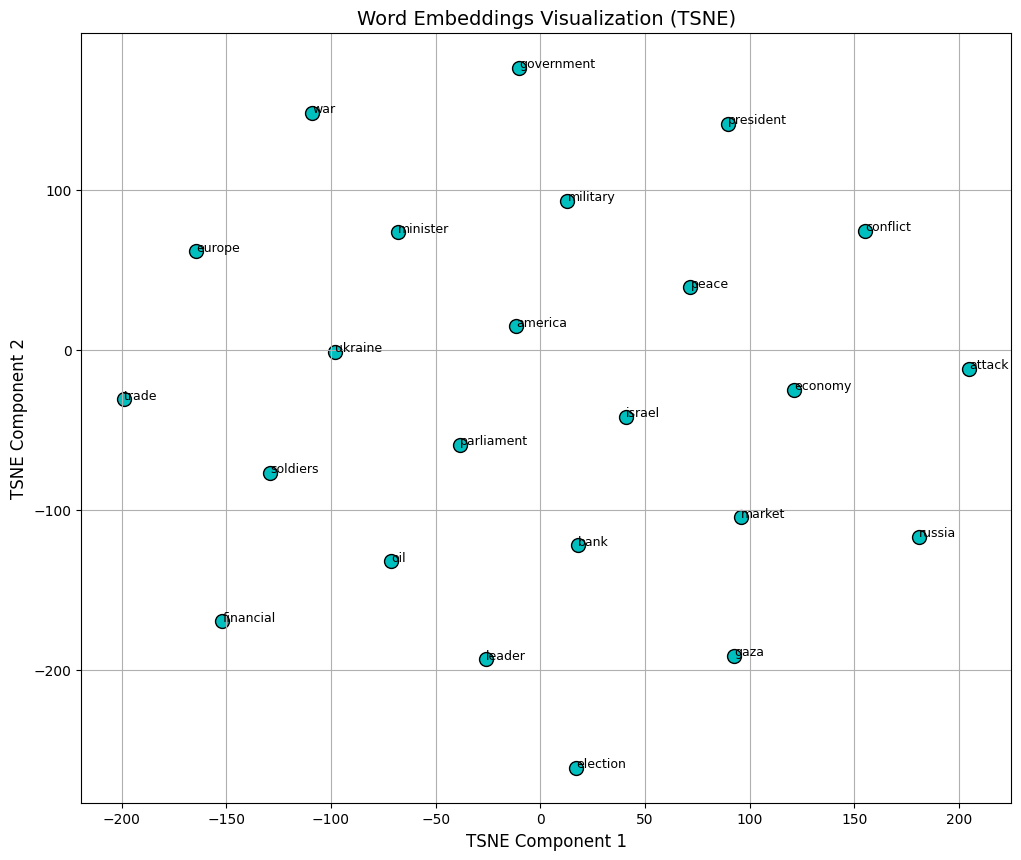

In [26]:
# --- Visualize Word Embeddings ---

words_for_viz = [
    # Countries/Regions
    "ukraine", "russia", "israel", "gaza", "europe", "america",
    # Political Roles/Concepts
    "president", "government", "election", "parliament", "minister", "leader",
    # Conflict/Military
    "war", "conflict", "attack", "military", "soldiers", "peace",
    # Economy/Finance
    "economy", "market", "bank", "financial", "oil", "trade"
]
viz_technique = 'TSNE' # 'PCA' or 'TSNE'

if nlp and hasattr(nlp.vocab, 'vectors') and nlp.vocab.vectors.shape[0] > 0:
    print(f"\n--- Visualizing Word Embeddings using {viz_technique} ---")

    valid_words_viz = [w for w in words_for_viz if nlp.vocab.has_vector(w)]
    if len(valid_words_viz) < 5:
        print(f"Need more words with vectors (found {len(valid_words_viz)}) for meaningful visualization.")
    else:
        vectors_viz = np.array([nlp(word).vector for word in valid_words_viz])

        print(f"Applying {viz_technique}...")
        if viz_technique == 'PCA':
            reducer = PCA(n_components=2, random_state=42)
        else:
            perplexity_value = min(30, len(valid_words_viz) - 1) # Adjust perplexity
            reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)

        try:
            vectors_2d = reducer.fit_transform(vectors_viz)

            plt.figure(figsize=(12, 10))
            plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='c', s=100)
            for i, word in enumerate(valid_words_viz):
                plt.annotate(word, (vectors_2d[i, 0] + 0.1, vectors_2d[i, 1] + 0.1), fontsize=9)

            plt.title(f'Word Embeddings Visualization ({viz_technique})', fontsize=14)
            plt.xlabel(f'{viz_technique} Component 1', fontsize=12)
            plt.ylabel(f'{viz_technique} Component 2', fontsize=12)
            plt.grid(True)
            plt.show()

        except Exception as viz_e:
            print(f"Error during visualization: {viz_e}")
else:
    print("\nCannot visualize embeddings: SpaCy model with vectors not loaded.")

#### t-SNE (t-distributed Stochastic Neighbor Embedding)

**t-SNE** is a popular **dimensionality reduction** technique primarily used for **visualizing** high-dimensional datasets (like word embeddings which can have hundreds of dimensions) in a low-dimensional space (typically 2D or 3D).

**How it works:**

1.  **Similarity Modeling:** It first models the similarity between pairs of high-dimensional points using probabilities. Points that are close together have a high probability of being "picked" as neighbors.
2.  **Low-Dimensional Mapping:** It then tries to create a similar probability distribution for the points mapped into the low-dimensional space (e.g., a 2D plot).
3.  **Minimizing Divergence:** The algorithm iteratively adjusts the positions of the points in the low-dimensional space to minimize the difference (Kullback-Leibler divergence) between the two probability distributions (high-dimensional vs. low-dimensional).

**Key Characteristics for Interpretation:**

* **Preserves Local Structure:** t-SNE excels at revealing the underlying **clusters** or groupings present in the data. Points that are close neighbors in the original high-dimensional space tend to end up close together in the low-dimensional map.
* **Non-Linear:** It can capture complex, non-linear relationships between data points.
* **Cluster Separation vs. Distance:** While it groups similar items, the *distances between different clusters* in the t-SNE plot don't always accurately represent the actual separation in the original high-dimensional space. Focus on *which points cluster together*, rather than the exact spacing between clusters.

In essence, t-SNE helps us *see* potential groupings and similarities in complex data that would otherwise be impossible to visualize directly.

#### Interpretation of the t-SNE Plot

This plot visualizes the relationships between selected words based on their pre-trained embeddings, reduced to two dimensions using t-SNE. Remember that t-SNE primarily preserves **local** structure, meaning words close together are likely semantically similar based on the contexts the model learned, but the distances **between** distinct clusters aren't always proportionally meaningful.

1.  **Geopolitical Entities:**
    * Countries involved in recent conflicts like **"ukraine"**, **"russia"**, **"israel"**, and **"gaza"** appear somewhat dispersed but generally occupy the middle-to-right side of the plot. **"russia"** and **"gaza"** are positioned relatively near each other, perhaps reflecting their frequent co-occurrence in conflict-related news.
    * Broader regions like **"europe"** and **"america"** are located more towards the left and center, distinct from the specific conflict zones.

2.  **Conflict & Military Terms:**
    * There's a noticeable grouping of terms related to conflict: **"war"**, **"conflict"**, **"attack"**, **"military"**, and **"soldiers"**.
    * **"war"** and **"conflict"** are relatively close, as expected.
    * **"military"** and **"soldiers"** also appear near each other, linked semantically.
    * **"peace"** is distinctly positioned away from the main conflict cluster, appropriately representing an opposing concept.

3.  **Politics & Governance:**
    * Words describing political roles and systems like **"government"**, **"president"**, **"minister"**, **"parliament"**, and **"leader"** form a loose cluster primarily in the upper half of the plot.
    * Interestingly, **"election"** is positioned far south, quite separate from the other governance terms. This might suggest its usage context (e.g., specific election events) differs significantly in the training data from general governing terms.

4.  **Economy & Finance:**
    * Economic terms like **"economy"**, **"market"**, **"trade"**, **"financial"**, **"bank"**, and **"oil"** are largely grouped in the lower-left and central-lower regions.
    * **"trade"** and **"financial"** are close on the far left, while **"bank"**, **"market"**, **"oil"**, and **"economy"** form another nearby group, indicating strong semantic links within the economic domain.

**Overall:** This visualization effectively demonstrates that the word embeddings capture semantic relationships. Words belonging to distinct conceptual categories (geopolitics, conflict, governance, economy) tend to cluster together in the 2D space, confirming that the model has learned meaningful associations from its training data. The separation between clusters like "war"/"conflict" and "economy"/"market" highlights the model's ability to differentiate between major topics.

## Named Entity Recognition

### 10. Extract and visualize Named Entities... Who are known personalities?


--- Extracting Named Entities using 'en_core_web_md' ---
Processing documents for NER...


NER Processing: 100%|██████████| 60/60 [00:09<00:00,  6.05it/s]


NER processing complete in 9.94 seconds.
Processed 60 documents. Found 11690 total entities.
Found 1171 potential PERSON entities (after filtering).

--- Top Mentioned Personalities (Simple Count) ---
- Nicolas Sarkozy: 68 mentions
- Daniel Naroditsky: 39 mentions
- Marshall Cohen: 25 mentions
- Eric Davis: 23 mentions
- Martha Stewart'S: 20 mentions
- Oksana Baiul'S: 20 mentions
- Justin Nelson: 19 mentions
- Donald Trump: 17 mentions
- George Santos: 16 mentions
- Lou Dobbs: 15 mentions
- Rudy Giuliani: 13 mentions
- Tucker Carlson: 13 mentions
- Doug Martin: 13 mentions
- Sidney Powell: 12 mentions
- Joe Biden: 10 mentions


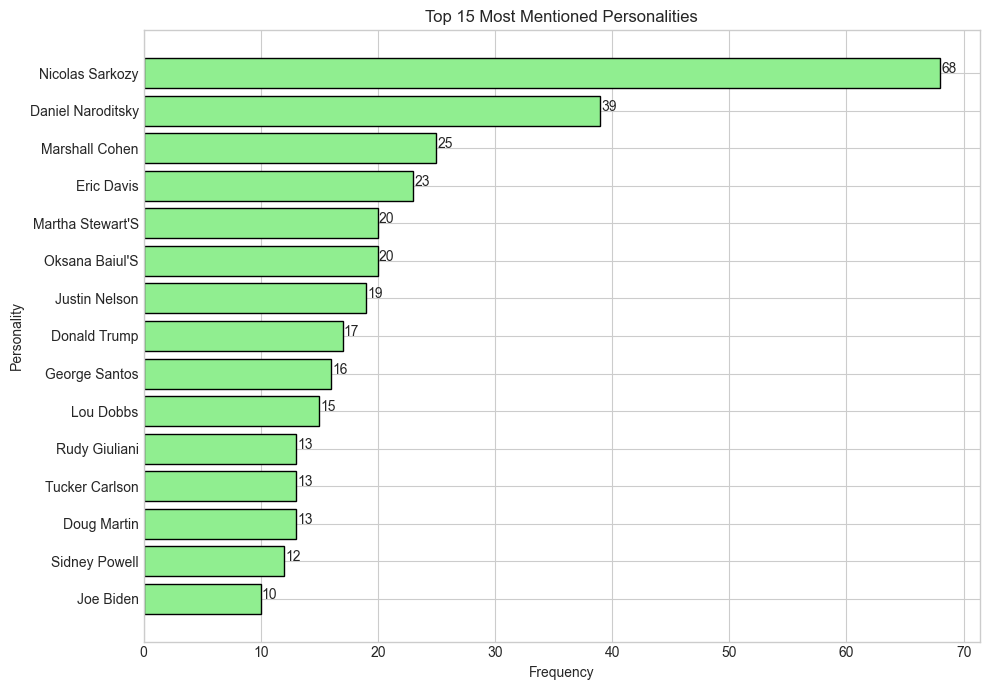

In [28]:
# --- Named Entity Recognition (NER) with SpaCy ---

if nlp and corpus:
    print(f"\n--- Extracting Named Entities using '{spacy_model_name}' ---")
    start_time = time.time()
    all_entities = []
    person_entities = []
    batch_size = 50
    entity_count = 0
    processed_docs = 0

    print("Processing documents for NER...")
    try:
        from tqdm import tqdm
        iterator = tqdm(nlp.pipe(corpus, batch_size=batch_size), total=len(corpus), desc="NER Processing")
    except ImportError:
        print("tqdm not installed, processing without progress bar.")
        iterator = nlp.pipe(corpus, batch_size=batch_size)

    for doc in iterator:
        processed_docs += 1
        for ent in doc.ents:
            entity_count += 1
            all_entities.append((ent.text.strip(), ent.label_))
            if ent.label_ == "PERSON":
                person_name = ent.text.strip().title()
                # Simple filter: require space and length > 3
                if len(person_name) > 3 and ' ' in person_name:
                     person_entities.append(person_name)

    end_time = time.time()
    print(f"\nNER processing complete in {end_time - start_time:.2f} seconds.")
    print(f"Processed {processed_docs} documents. Found {entity_count} total entities.")
    print(f"Found {len(person_entities)} potential PERSON entities (after filtering).")

    # --- Analyze PERSON Entities ---
    if person_entities:
        person_counts = Counter(person_entities)
        top_persons = person_counts.most_common(15)

        print("\n--- Top Mentioned Personalities (Simple Count) ---")
        if not top_persons:
            print("No prominent personalities found.")
        else:
            for name, count in top_persons:
                print(f"- {name}: {count} mentions")

            # --- Visualization ---
            names = [item[0] for item in top_persons]
            counts = [item[1] for item in top_persons]

            plt.figure(figsize=(10, 7))
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.barh(range(len(names)), counts, color='lightgreen', edgecolor='black')
            plt.yticks(range(len(names)), names)
            plt.gca().invert_yaxis()
            plt.xlabel("Frequency")
            plt.ylabel("Personality")
            plt.title("Top 15 Most Mentioned Personalities")
            for index, value in enumerate(counts):
                plt.text(value + 0.1, index, str(value))
            plt.tight_layout()
            plt.show()
    else:
        print("\nNo PERSON entities passed filtering.")

elif not nlp:
    print("\nCannot perform NER: SpaCy model not loaded.")
elif not corpus:
    print("\nCannot perform NER: Corpus is empty.")

Based on the Named Entity Recognition output from the articles, here are some of the known personalities mentioned:

* **Nicolas Sarkozy** (Former President of France)
* **Donald Trump** (Former US President)
* **Joe Biden** (Current US President)
* **Rudy Giuliani** (Former NYC Mayor and lawyer)
* **Tucker Carlson** (Political commentator)
* **Lou Dobbs** (Former TV host)
* **Sidney Powell** (Lawyer)
* **George Santos** (Former US Representative)
* **Martha Stewart** (Businesswoman, TV personality - mentioned as "Martha Stewart'S")
* **Oksana Baiul** (Olympic figure skater - mentioned as "Oksana Baiul'S")
* **Daniel Naroditsky** (Chess Grandmaster)

Other names like Marshall Cohen, Eric Davis, Justin Nelson, and Doug Martin were also frequently mentioned, though their public recognition might vary or be specific to the context of the articles (e.g., journalists, lawyers, athletes).